In [ ]:
# import library 
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.model_selection import StratifiedKFold

from datamodule.DaTdataset import DaTdataset, MinMaxNormalization, SBRMeanStdNormalization, calc_sbr_mean_std
from datamodule.helper import split_data, feature_extract
from config import *

In [4]:
train_data, train_labels, prototype_data, prototype_labels, test_data, test_labels, excluded_data, excluded_labels = split_data(
    TABLE_PATH,
    DATA_PATH,
    SBR_COLUMNS,
    SPLIT_RATIO,
    EXCLUDE,
    RANDOM_SEED,
    TEST_FIX_SEED
)

train_means = []
train_stds = []

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for n_fold, (train_idx, valid_idx) in enumerate(k_fold.split(train_data, train_labels)):
    if n_fold != TEST_FOLD:
        continue

    X_train, X_valid = [train_data[i] for i in train_idx], [train_data[i] for i in valid_idx]
    y_train, y_valid = [train_labels[i] for i in train_idx], [train_labels[i] for i in valid_idx]

    train_mean, train_std = calc_sbr_mean_std(X_train)
    train_means.append(train_mean.cpu().numpy())
    train_stds.append(train_std.cpu().numpy())

    transform = transforms.Compose([
        transforms.ToTensor(),
        MinMaxNormalization(0.0, 1.0),
        transforms.Lambda(lambda x: x.type(torch.float32)),
        transforms.Lambda(lambda x: x.unsqueeze(0)),
        transforms.Lambda(lambda x: x[..., 13:-14, 13:-14, 6:-7])
    ])

    sbr_transform = transforms.Compose([
        SBRMeanStdNormalization(train_mean, train_std)
    ])

    train_dataset = DaTdataset(X_train, y_train, transform, sbr_transform)
    valid_dataset = DaTdataset(X_valid, y_valid, transform, sbr_transform)
    prototype_dataset = DaTdataset(prototype_data, prototype_labels, transform, sbr_transform)
    test_dataset = DaTdataset(test_data, test_labels, transform, sbr_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    prototype_loader = DataLoader(prototype_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

base_dir = os.path.join(STUDY_NAME, f"fold_{TEST_FOLD}")
model = MODEL(num_classes=1).cuda()
model.load_state_dict(torch.load(os.path.join(base_dir, "best.pth")))
model.eval()

prototype_featuremaps, prototype_sbrs, valid_featuremaps, valid_sbrs, test_featuremaps, test_sbrs, feature_maps_length = feature_extract(
    model, prototype_loader, valid_loader, test_loader
)


prototype
    fmap: torch.Size([137, 512])  torch.Size([137, 6])
valid
    fmap: torch.Size([83, 512])  torch.Size([83, 6])
test
    fmap: torch.Size([137, 512])  torch.Size([137, 6])


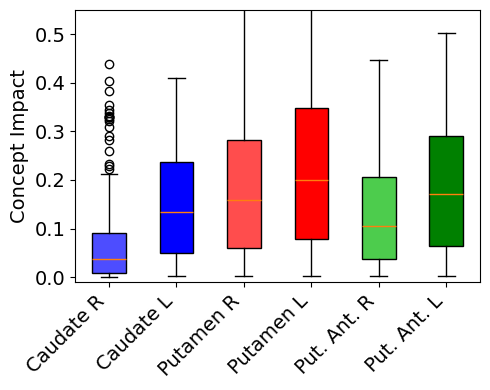

In [2]:
SAVE_PATH = os.path.join(STUDY_NAME, f"fold_{TEST_FOLD}", "cgv")
results = joblib.load(os.path.join(SAVE_PATH, "concept_impact_results.joblib"))

colors = ['#4D4DFF', '#0000FF', '#FF4D4D', '#FF0000', '#4DCC4D', '#008000']
labels = ['Caudate R', 'Caudate L', 'Putamen R', 'Putamen L', 'Put. Ant. R', 'Put. Ant. L']

impact = results["impact"]

for i in range(impact.shape[1]):  
    fig, ax = plt.subplots(figsize=(5, 4))

    box = ax.boxplot(impact[:,i,:], patch_artist=True)


    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xticks(range(1, len(SBR_COLUMNS) + 1)) 
    ax.tick_params(axis='both', labelsize=14) 
    ax.set_ylabel("Concept Impact", fontsize=14)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)

    plt.tight_layout()
    ax.set_ylim(0.0-0.01, 0.5+0.05)
    plt.savefig(os.path.join(SAVE_PATH, f'CGV_boxplot_{i}.svg'))
    plt.show()
plt.close()

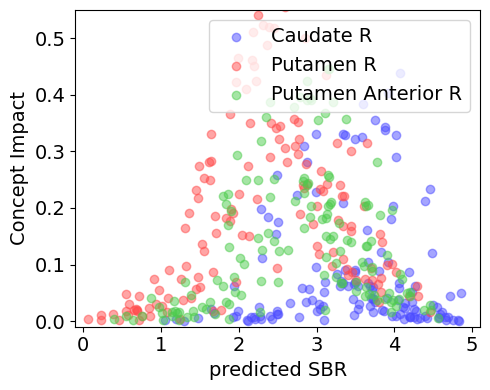

In [5]:
sbr_pred = results["sbr_pred"]
impact = results["impact"]


for fmap_idx in range(impact.shape[1]):

    fig, ax = plt.subplots(figsize=(5, 4)) 

    i = 0

    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Caudate R')

    i += 2
    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Putamen R')

    i += 2
    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Putamen Anterior R')
    ax.legend(loc='upper right', fontsize=14)
    ax.set_ylim(0.0-0.01, 0.5+0.05)
    ax.set_xlim(0.0-0.1, 5.0+0.1)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel("predicted SBR", fontsize=14)
    ax.set_ylabel("Concept Impact", fontsize=14)
    plt.savefig(os.path.join(SAVE_PATH, f'CGV_scatter_R_{fmap_idx}.svg'))
    
    plt.tight_layout()
    plt.show()
    plt.close()


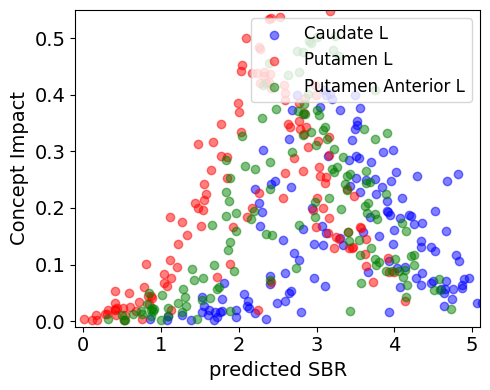

In [6]:
sbr_pred = results["sbr_pred"]
impact = results["impact"]

for fmap_idx in range(impact.shape[1]):

    fig, ax = plt.subplots(figsize=(5, 4)) 

    i = 1

    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Caudate L')

    i += 2
    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Putamen L')

    i += 2
    cor = (sbr_pred[:,fmap_idx, i] + train_means[0][i]) / train_stds[0][i]
    ax.scatter(cor, impact[:, fmap_idx, i], color=colors[i], alpha=0.5, label='Putamen Anterior L')
    ax.legend(loc='upper right', fontsize=12)
    ax.set_ylim(0.0-0.01, 0.5+0.05)
    ax.set_xlim(0.0-0.1, 5.0+0.1)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel("predicted SBR", fontsize=14)
    ax.set_ylabel("Concept Impact", fontsize=14)
    plt.savefig(os.path.join(SAVE_PATH, f'CGV_scatter_L_{fmap_idx}.svg'))
    plt.tight_layout()
    plt.show()
    plt.close()


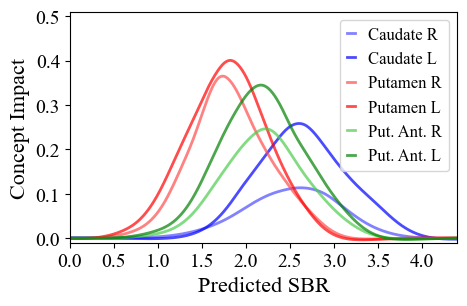

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel

gprs = []
sbr_pred = results["sbr_pred"]
# impact = results["impact"]

for fmap_idx in range(impact.shape[1]):
    gprs_d1 = []
    for i in range(0, 6):
        x, y = sbr_pred[:, fmap_idx, i], impact[:, fmap_idx, i]
        X = x.reshape(-1, 1)
        tx = np.linspace(x.min()-10, x.min(), len(x))
        ty = np.zeros_like(tx)
        tx = tx.reshape(-1, 1)
        
        ttx = np.linspace(x.max(), x.max()+10, len(x))
        tty = np.zeros_like(ttx)
        ttx = ttx.reshape(-1, 1)

        X = np.concatenate((X, tx, ttx))
        y = np.concatenate((y, ty, tty))

        kernel = C(1.0) * Matern(length_scale=1, nu=1.5) + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10, normalize_y=True)
        gpr.fit(X, y)

        gprs_d1.append(gpr)
        X_pred = np.linspace(-10, 10, 1000).reshape(-1, 1)
        y_pred, sigma = gpr.predict(X_pred, return_std=True)
    gprs.append(gprs_d1)

def plot_gpr_models(gprs, means, stds, x_values, num_points=1000):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(figsize=(5, 3))
    color_palettes = {
        1: ['#1f78b4', '#a6cee3', '#33a02c', '#b2df8a', '#e31a1c', '#fb9a99'], 
        2: ['#4c72b0', "#2c3b43", '#55a868', '#88c399', '#c44e52', '#ff9896'],
        3: ['#0173b2', '#aec7e8', '#029e73', '#a7d6a5', '#d55e00', '#fdae61'],
        4: ['#4D4DFF', '#0000FF', '#FF4D4D', '#FF0000', '#4DCC4D', '#008000']
    }
    colors = color_palettes.get(4, color_palettes[1]) 

    roi = ['Caudate R', 'Caudate L', 'Putamen R', 'Putamen L', 'Put. Ant. R', 'Put. Ant. L']

    for i in range(6):
        gpr = gprs[i]
        mean, std = means[i], stds[i]
        x_raw = x_values[i]

        x_norm_pred = np.linspace((x_raw.min() - mean) / std, (x_raw.max() - mean) / std, num_points).reshape(-1, 1)
        y_pred, y_std = gpr.predict(x_norm_pred, return_std=True)
        x_pred = x_norm_pred * std + mean

        plt.plot(x_pred, y_pred, color=colors[i], label=f"{roi[i]}", linewidth=2, alpha=0.7)


    plt.ylim(0.0-0.01, 0.5+0.01)
    plt.xlabel("Predicted SBR", fontsize=16)
    plt.ylabel("Concept Impact", fontsize=16)
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.xlim(0, 4.4)
    plt.legend(fontsize=12, handlelength=0.5)
    plt.savefig(os.path.join(SAVE_PATH, f'CGV_GPR.png'))
    plt.show()

x_values = [np.linspace(-1, 5, 1000).reshape(-1, 1) for _ in range(6)]

plot_gpr_models(gprs[0], train_means[0], train_stds[0], x_values)

plt.close()